In [1]:
import numpy as np
import os
import gzip
import struct
import logging
import mxnet as mx
import matplotlib.pyplot as plt # 这是常用的绘图库
logging.getLogger().setLevel(logging.DEBUG)

def read_data(label_url, image_url): # 读入训练数据
    with gzip.open(label_url) as flbl: # 打开标签文件
        magic, num = struct.unpack(">II", flbl.read(8)) # 读入标签文件头
        label = np.fromstring(flbl.read(), dtype=np.int8) # 读入标签内容
    with gzip.open(image_url, 'rb') as fimg: # 打开图像文件
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16)) # 读入图像文件头，rows和cols都会是28
        image = np.fromstring(fimg.read(), dtype=np.uint8) # 读入图像内容
        image = image.reshape(len(label), 1, rows, cols) # 设置为正确的数组格式
        image = image.astype(np.float32)/255.0 # 归一化为0到1区间
    return (label, image)

# 读入数据
(train_lbl, train_img) = read_data('train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data('t10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz')
 
batch_size = 32 # 批大小

# 迭代器
train_iter = mx.io.NDArrayIter(train_img, train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(val_img, val_lbl, batch_size)  

for i in range(10): # 输出前10个数字
    plt.subplot(1,10,i+1) # 这里的语句可参见matplotlib库的介绍
    plt.imshow(train_img[i].reshape(28,28), cmap='Greys_r') # 新版 matplotlib 需要这样 reshape
    plt.axis('off')
plt.show() # 显示图像
print('label: %s' % (train_lbl[0:10],)) # 显示对应的标签

c:\python3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]
c:\python3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


<Figure size 640x480 with 10 Axes>

label: [5 0 4 1 9 2 1 3 1 4]


In [2]:
data = mx.symbol.Variable('data')

# 第1个卷积层，以及相应的BN和非线性，有32个5*5卷积
conv1 = mx.sym.Convolution(data=data, name="conv1", kernel=(5,5), num_filter=32)
# 对于BN层我们往往会加上fix_gamma=False这个参数
bn1 = mx.sym.BatchNorm(data=conv1, name="bn1", fix_gamma=False)
act1 = mx.sym.Activation(data=bn1, name="act1", act_type="relu")
# 第1个池化层，使用了3*3大小和2*2步长
pool1 = mx.sym.Pooling(data=act1, name="pool1", pool_type="max", kernel=(3,3), stride=(2,2))

# 第2个卷积层，以及相应的BN和非线性，有64个5*5卷积
conv2 = mx.sym.Convolution(data=pool1, name="conv2", kernel=(5,5), num_filter=64)
bn2 = mx.sym.BatchNorm(data=conv2, name="bn2", fix_gamma=False)
act2 = mx.sym.Activation(data=bn2, name="act2", act_type="relu")
# 第2个池化层，使用了3*3大小和2*2步长
pool2 = mx.sym.Pooling(data=act2, name="pool2", pool_type="max", kernel=(3,3), stride=(2,2))

# 第3个卷积层，有10个3*3卷积
conv3 = mx.sym.Convolution(data=pool2, name="conv3", kernel=(3,3), num_filter=10)
# 第3个池化层，这里设置global_pool进行全局池化，会忽略kernel的值
pool3 = mx.sym.Pooling(data=conv3, name="pool3", global_pool=True, pool_type="avg", kernel=(1,1))
# 将图像摊平，这里的效果是将10张1*1的图像摊平，因此得到10个数
flatten = mx.sym.Flatten(data=pool3, name="flatten")
# SoftMax层，将10个数变为10个分类的概率
net = mx.sym.SoftmaxOutput(data=flatten, name='softmax')


# 我们将调用MXNet中的viz库，需要先告知MXNet输入数据的格式
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.print_summary(symbol=net, shape=shape)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          1x28x28                 0                                           
________________________________________________________________________________________________________________________
conv1(Convolution)                                  32x24x24                832         data                            
________________________________________________________________________________________________________________________
bn1(BatchNorm)                                      32x24x24                64          conv1                           
________________________________________________________________________________________________________________________
act1(Activation)                

In [3]:
#mx.viz.plot_network(symbol=net, shape=shape).view() # 注意需安装 Graphviz

In [4]:
#val_iter.reset() # 将val_iter重置，保证是从头开始提供数据
# 前向传播，用next()进行val_iter的迭代，每次调用可得到一个batch的数据
#module.forward(val_iter.next(), is_train=False) 
#out = module.get_outputs()[0].asnumpy() # 得到输出
# 将输出做一些美观处理
#print(zip(out.argmax(axis=1), out.max(axis=1)))

In [9]:
# 由于训练数据量较大，这里采用了GPU，若读者没有GPU，可修改为CPU
#module = mx.mod.Module(symbol=net, context=mx.gpu(0))
module = mx.mod.Module(symbol=net)

model_prefix = 'MNIST_symb.params'
checkpoint = mx.callback.do_checkpoint(model_prefix)

module.fit(
    train_iter,
    eval_data=val_iter,
    optimizer = 'sgd', 
# 采用0.03的初始学习速率，并在每60000个样本后（即每1个epoch后）将学习速率缩减为之前的0.9倍
    optimizer_params = {'learning_rate' : 0.03, 'lr_scheduler' : mx.lr_scheduler.FactorScheduler(step=60000/batch_size, factor=0.9)},
    num_epoch = 10,     
    batch_end_callback = mx.callback.Speedometer(batch_size, 60000/batch_size),
    epoch_end_callback = checkpoint,
)

#module._symbol.save('sysbol.json')
#module.save_params("sysbol.params")

INFO:root:Epoch[0] Train-accuracy=0.973133
INFO:root:Epoch[0] Time cost=93.813
INFO:root:Saved checkpoint to "MNIST_symb.params-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.989716
INFO:root:Update[1876]: Change learning rate to 2.70000e-02
INFO:root:Epoch[1] Train-accuracy=0.990300
INFO:root:Epoch[1] Time cost=93.921
INFO:root:Saved checkpoint to "MNIST_symb.params-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.992113
INFO:root:Update[3751]: Change learning rate to 2.43000e-02
INFO:root:Epoch[2] Train-accuracy=0.993200
INFO:root:Epoch[2] Time cost=101.545
INFO:root:Saved checkpoint to "MNIST_symb.params-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.991913
INFO:root:Update[5626]: Change learning rate to 2.18700e-02
INFO:root:Epoch[3] Train-accuracy=0.994550
INFO:root:Epoch[3] Time cost=111.691
INFO:root:Saved checkpoint to "MNIST_symb.params-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.992812
INFO:root:Update[7501]: Change learning rate to 1.96830e-02
IN

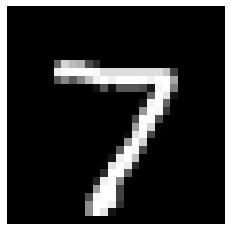

7


In [6]:
plt.imshow(val_img[0].reshape(28,28), cmap='Greys_r') # 新版 matplotlib 需要这样 reshape
plt.axis('off')
plt.show()
print(val_lbl[0])

4 9


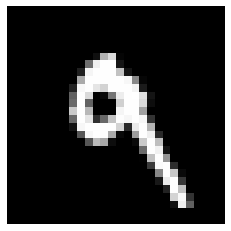

0 1


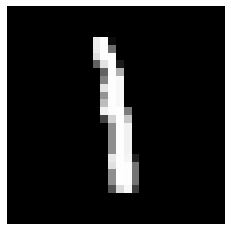

5 2


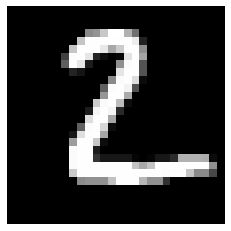

In [7]:
val_iter.reset()
for i in range(0,15):
    # 如前所述，每次调用val_iter.next()都会得到一个batch的数据 
    module.forward(val_iter.next(), is_train=False)
    out = module.get_outputs()[0].asnumpy().argmax(axis=1)
    for j in range(0,len(out)):
        if out[j] != val_lbl[i*batch_size + j]: # 是否错误识别？
            print(out[j], val_lbl[j]) # 输出错误的情况
            plt.imshow(val_img[j].reshape(28,28), cmap='Greys_r')
            plt.axis('off')
            plt.show()

In [8]:
# 定义一个简单数据结构，方便后续 module 读取数据
from collections import namedtuple
MyBatch = namedtuple('MyBatch', ['data', 'label'])

# 对于不熟悉 namedtuple 的朋友，这里举例说明 namedtuple 的运作方式：
# 如果此时执行 MyBatchExample = MyBatch('abc', 'def')
# 那么 print(MyBatchExample.data) 就会输出 'abc'
# 而 print(MyBatchExample.label) 就会输出 'def'

# 将 module 重新绑定为批大小为1
new_batch_size = 1
module.bind(data_shapes=[('data', (new_batch_size, 1, 28, 28))], label_shapes=[('softmax_label', (new_batch_size,))], force_rebind=True, for_training=False) # 设置force_rebind为True，说明是在重新绑定；设置for_training为False，说明只作前向传播

# 这里的数据使用val_img的第1张。我们也可送入自己生成的数据
# 这里将MyBatch的第2个参数设为None，因为它对应标签，而运行网络不需要标签
MyBatchData = MyBatch([mx.nd.array(val_img[0].reshape(1, 1, 28, 28).astype(np.float32))], None)

# 运行网络，module 会读取 MyBatchData.data 和 MyBatchData.label
module.forward(MyBatchData) 
# 关闭 print 的科学计数法显示，让结果更美观
np.set_printoptions(suppress=True)
# 输出网络运行结果
print(module.get_outputs()[0].asnumpy())

[[0.         0.00000001 0.00000007 0.00000019 0.         0.
  0.         0.9999988  0.         0.00000099]]
